In [5]:
%load_ext watermark
%matplotlib notebook


CEPH1463 Setup
==============

We first download the ceph1463 VCF and ped into our data-directory and then run peddy.

We can see the time taken for each check.


In [1]:
DATA = "/data/" # directory where VCFs are KEPT

In [3]:
%%bash -s $DATA
DATA=$1
echo "$1"
mkdir -p plots/
python -m peddy --prefix plots/ceph1463 --plot ${DATA}/ceph1463.vcf.gz ${DATA}/ceph1463.ped

/data/

ped_check
ran in 7.6 seconds
het_check
ran in 10.5 seconds
sex_check
ran in 5.7 seconds


/media/brentp/transcend/gemini_install/data/anaconda/lib/python2.7/site-packages/ipython-4.0.0-py2.7.egg/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
loaded and subsetted thousand-genomes genotypes in 0.4 seconds
ran randomized PCA on thousand-genomes samples at 18984 sites in 1.5 seconds
Projected thousand-genomes genotypes and sample genotypes and predicted ancestry via SVM in 0.2 seconds
sex-check: 12404 skipped / 100000 kept


HTML OUTPUT
===========

Below, we embed the HTML output that is the result of the run above.

As expected, we don't see any problems with this data from the well-studied 17-member CEPH pedigree.

In [4]:
from IPython.display import HTML
HTML(data="<iframe src='plots/ceph1463.html' width='100%' height='600px'></iframe>")

Compare to KING
===============

In order to compare to king we need to have plink (and king) installed. We show the time to run both of these on the dataset and then compare the results to those from peddy.

In [5]:
%%bash -s $DATA
DATA=$1
PATH=$DATA:$PATH

if [[ -x $(which plink2) ]]; then
    echo "OK"
else
    conda install -y -c bioconda plink2
fi
cd $DATA
if [[ -x $(which king) ]]; then
    echo "king"
else
    wget http://people.virginia.edu/~wc9c/KING/Linux-king.tar.gz
    tar xzvf Linux-king.tar.gz
fi
cd -

bash ../scripts/king-compare.sh $DATA/ceph1463.vcf.gz 

OK
king
/usr/local/src/peddy/data
ceph1463
PLINK v1.90p 64-bit (25 Mar 2016)          https://www.cog-genomics.org/plink2
(C) 2005-2016 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ceph1463.log.
Options in effect:
  --allow-extra-chr
  --biallelic-only
  --const-fid
  --geno 0.95
  --make-bed
  --out ceph1463
  --vcf /data//ceph1463.vcf.gz
  --vcf-half-call m

7885 MB RAM detected; reserving 3942 MB for main workspace.
Allocated 2956 MB successfully, after larger attempt(s) failed.
--vcf: ceph1463-temporary.bed + ceph1463-temporary.bim + ceph1463-temporary.fam
written.
(394182 variants skipped.)
7695880 variants loaded from .bim file.
17 people (0 males, 0 females, 17 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ceph1463.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 17 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%1

+ VCF=/data//ceph1463.vcf.gz
++ basename /data//ceph1463.vcf.gz .vcf.gz
+ prefix=ceph1463
+ echo ceph1463
+ /usr/bin/time plink2 --const-fid --allow-extra-chr --vcf /data//ceph1463.vcf.gz --make-bed --out ceph1463 --biallelic-only --geno 0.95 --vcf-half-call m
treat these as missing.
46.12user 1.56system 0:49.30elapsed 96%CPU (0avgtext+0avgdata 456356maxresident)k
3457392inputs+804936outputs (21major+110514minor)pagefaults 0swaps
+ /usr/bin/time king --ibs -b ceph1463.bed --kinship --prefix ceph1463
10.03user 0.91system 0:10.95elapsed 99%CPU (0avgtext+0avgdata 1880288maxresident)k
68952inputs+48outputs (3major+460231minor)pagefaults 0swaps


We can see that plink took 45 seconds and KING took 10.5 seconds to run. Now, we compare to the peddy results

<IPython.core.display.Javascript object>


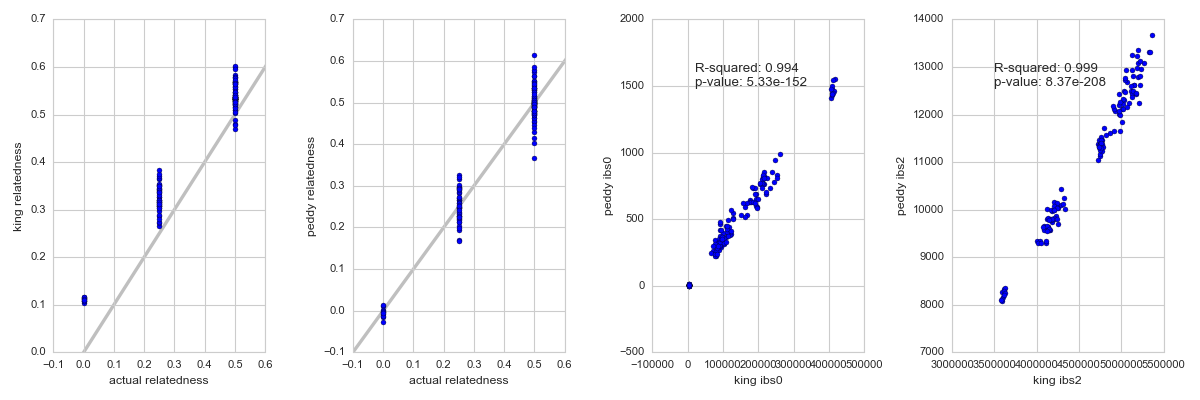

<IPython.core.display.Javascript object>


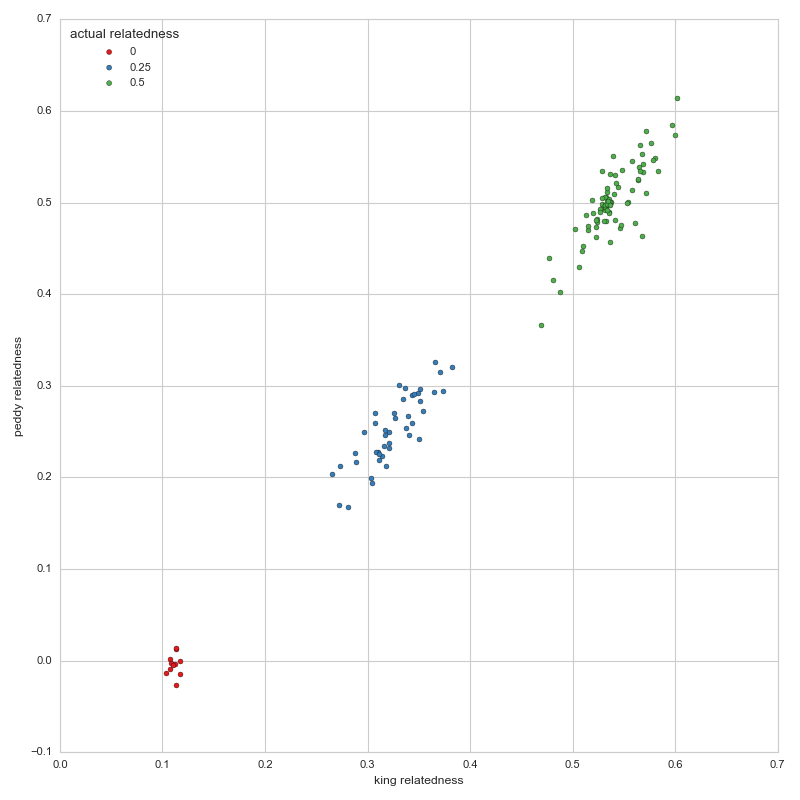

In [15]:
%run ../scripts/king-compare.py ceph1463.ibs $DATA/ceph1463.ped_check.csv $DATA/ceph-king-vs-peddy.eps

Convergence
===========

We sample 23,556 sites by default. Though the user can specify their own sites. We run peddy specifying the `--each` flag which will sub-sample
the sites to the number requested e.g. `--each 4` will have about 5900 sites.

We run the same command, only changing the value to each and then plot the convergence.


In [7]:
%%bash -s $DATA
DATA=$1
for e in $(seq 1 16); do
    python -m peddy --prefix plots/each-$e-ceph1463 ${DATA}/ceph1463.vcf.gz ${DATA}/ceph1463.ped --each $e 2> err
done


ped_check
ran in 5.5 seconds
het_check
ran in 10.0 seconds
sex_check
ran in 5.8 seconds

ped_check
ran in 2.9 seconds
het_check
ran in 9.6 seconds
sex_check
ran in 5.7 seconds

ped_check
ran in 2.0 seconds
het_check
ran in 9.9 seconds
sex_check
ran in 5.7 seconds

ped_check
ran in 1.7 seconds
het_check
ran in 9.5 seconds
sex_check
ran in 5.9 seconds

ped_check
ran in 1.3 seconds
het_check
ran in 9.9 seconds
sex_check
ran in 6.6 seconds

ped_check
ran in 1.3 seconds
het_check
ran in 10.6 seconds
sex_check
ran in 7.5 seconds

ped_check
ran in 1.6 seconds
het_check
ran in 12.0 seconds
sex_check
ran in 6.6 seconds

ped_check
ran in 1.5 seconds
het_check
ran in 10.1 seconds
sex_check
ran in 6.0 seconds

ped_check
ran in 1.0 seconds
het_check
ran in 10.1 seconds
sex_check
ran in 5.8 seconds

ped_check
ran in 0.9 seconds
het_check
ran in 10.7 seconds
sex_check
ran in 5.8 seconds

ped_check
ran in 0.9 seconds
het_check
ran in 12.3 seconds
sex_check
ran in 6.4 seconds

ped_check
ran in 0.8 sec

<IPython.core.display.Javascript object>


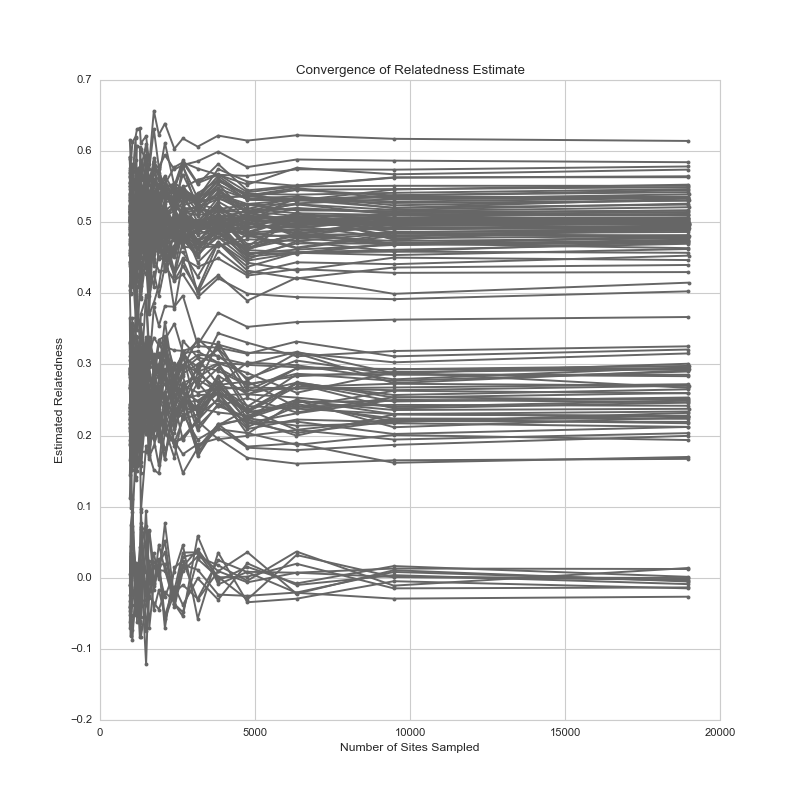

In [14]:

import toolshed as ts
import collections
from matplotlib import pyplot as plt

lines = collections.defaultdict(list)
for i in range(1, 21):
    f = "plots/each-%d-ceph1463.ped_check.csv" % i
    for d in ts.reader(f, sep=","):
        key = d['sample_a'], d['sample_b']
        lines[key].append((int(d['n']), float(d['rel'])))
        
        
fig, ax = plt.subplots(1, figsize=(10, 10))

color='0.9'
        
for (a, b), pairs in lines.items():
    xs, ys = zip(*pairs)
    ax.plot(xs, ys, marker='.', ls='-', color='0.4')
ax.set_xlabel('Number of Sites Sampled')
ax.set_ylabel('Estimated Relatedness')
ax.set_title('Convergence of Relatedness Estimate')
    
    

PCA Validation
==============

In [21]:
%%bash 
conda install -y -q -c r rpy2

Fetching package metadata .............
Solving package specifications .............

Package plan for installation in environment /media/brentp/transcend/gemini_install/data/anaconda:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    jbig-2.1                   |                0          29 KB
    jpeg-8d                    |                1         806 KB
    libffi-3.2.1               |                0          36 KB
    pcre-8.31                  |                0         534 KB
    pixman-0.32.6              |                0         2.4 MB
    glib-2.43.0                |                2         7.4 MB  r
    libtiff-4.0.6              |                1         1.5 MB
    cairo-1.12.18              |                6         594 KB
    harfbuzz-0.9.35            |                6         1.1 MB  r
    pango-1.36.8               |                3         796 KB  r
    r-base-

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R -i DATA 
#source("http://bioconductor.org/biocLite.R")
#biocLite("SNPRelate")
library("SNPRelate")

print(DATA)


gds = paste0(DATA, "/ceph.gds")

snpgdsVCF2GDS(paste0(DATA, "/", "ceph1463.vcf.gz"), gds, method="biallelic.only")

genofile <- snpgdsOpen(gds)
snpset <- snpgdsLDpruning(genofile, ld.threshold=0.2)
snpset.id <- unlist(snpset)

pca <- snpgdsPCA(genofile, snp.id=snpset.id, num.thread=2)

tab <- data.frame(sample.id = pca$sample.id,
    PC1 = pca$eigenvect[,1],    # the first eigenvector
    PC2 = pca$eigenvect[,2], 
    PC3 = pca$eigenvect[,3],
    PC4 = pca$eigenvect[,4],                
    stringsAsFactors = FALSE)
write.csv(tab, quote=F, row.names=F,file=paste0(DATA, "/ceph.snprelate.pcs.csv"))

/media/brentp/transcend/gemini_install/data/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: gdsfmt

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/media/brentp/transcend/gemini_install/data/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


[1] "/data/"
VCF Format ==> SNP GDS Format
Method: exacting biallelic SNPs
Number of samples: 17
Parsing "/data//ceph1463.vcf.gz" ...
	import 6644002 variants.
+ genotype   { Bit2 17x6644002, 28.2 MB } *
Optimize the access efficiency ...
Clean up the fragments of GDS file:
	open the file "/data//ceph.gds" (size: 82400978)
	# of fragments in total: 1025
	save it to "/data//ceph.gds.tmp"
	rename "/data//ceph.gds.tmp" (size: 82388918)
	# of fragments in total: 20
SNP pruning based on LD:
Excluding 241647 SNPs on non-autosomes
Excluding 484222 SNPs (monomorphic: TRUE, < MAF: NaN, or > missing rate: NaN)
Working space: 17 samples, 5918133 SNPs
	Using 1 (CPU) core
	Sliding window: 500000 basepairs, Inf SNPs
	|LD| threshold: 0.2
Chromosome 1: 0.73%, 3648/496985
Chromosome 10: 0.66%, 2139/322516
Chromosome 11: 0.66%, 2113/318973
Chromosome 12: 0.67%, 2066/307819
Chromosome 13: 0.66%, 1566/237499
Chromosome 14: 0.68%, 1443/211736
Chromosome 15: 0.69%, 1323/192465
Chromosome 16: 0.66%, 1357/204

<IPython.core.display.Javascript object>


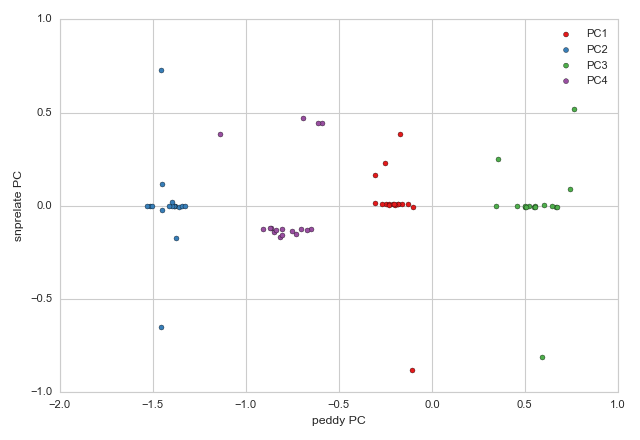

In [7]:
import toolshed as ts
from matplotlib import pyplot as plt

peddy_pcs = {}
snprelate_pcs = {}

for d in ts.reader(DATA + "/ceph1463.het_check.csv", sep=","):
    peddy_pcs[d['sample_id']] = [float(d["PC%d" % i]) for i in range(1, 5)]
    
for d in ts.reader(DATA + "/ceph.snprelate.pcs.csv", sep=","):
    snprelate_pcs[d['sample.id']] = [float(d["PC%d" % i]) for i in range(1, 5)]


import seaborn as sns
sns.set_style('whitegrid')

colors = sns.color_palette("Set1", 4)

fig, ax = plt.subplots(1)

keys = peddy_pcs.keys()
for i in range(4):
    xs = [peddy_pcs[k][i] for k in keys]
    ys = [snprelate_pcs[k][i] for k in keys]
    ax.scatter(xs, ys, c=colors[i], label="PC%d" % (i + 1))

ax.set_xlabel("peddy PC")
ax.set_ylabel("snprelate PC")

plt.legend()
plt.tight_layout()
plt.show()
    

CEPH Error
==========

To demonstrate the use of `peddy`, we **introduce a pedigree error** on a smaller-subset. Note that we see some **unknown sample** warnings because we took a subset of the pedigree file and some samples that are listed as parents no longer appear in the file.

In [9]:
%%bash -s $DATA
DATA=$1
if [[ ! -e $DATA/ceph1463.bad.ped ]]; then
    wget --quiet -O $DATA/ceph1463.bad.ped https://github.com/brentp/peddy/raw/master/data/ceph1463.bad.ped
fi

python -m peddy --prefix plots/bad --plot ${DATA}/ceph1463.vcf.gz ${DATA}/ceph1463.bad.ped


ped_check
ran in 11.9 seconds
het_check
ran in 16.4 seconds
sex_check
ran in 8.6 seconds


unknown sample: NA12889 in family: CEPH1463
unknown sample: NA12892 in family: CEPH1463
unknown sample: NA12890 in family: CEPH1463
unknown sample: NA12891 in family: CEPH1463
/media/brentp/transcend/gemini_install/data/anaconda/lib/python2.7/site-packages/ipython-4.0.0-py2.7.egg/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
loaded and subsetted thousand-genomes genotypes in 0.5 seconds
ran randomized PCA on thousand-genomes samples at 15839 sites in 3.7 seconds
Projected thousand-genomes genotypes and sample genotypes and predicted ancestry via SVM in 0.3 seconds
sex-check: 9883 skipped / 100000 kept


In [10]:
HTML(data="<iframe src='plots/bad.html' width='100%' height='600px'></iframe>")

In [11]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
%watermark -v -m -p peddy,scipy,numpy,cyvcf2,scikit-learn,pandas,networkx,toolshed

CPython 2.7.12
IPython 4.0.0

peddy 0.2.2
scipy 0.17.1
numpy 1.10.4
cyvcf2 0.4.1
scikit-learn 0.17.1
pandas 0.18.0
networkx 1.11
toolshed 0.4.5

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.16.0-71-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
